# Stock For Real
>created by vikky

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from datetime import datetime
from datetime import timedelta

### 读取文件

In [2]:
path = '../stock_data/'
file_name = os.listdir(path)[0]
df = pd.read_csv(path+file_name,encoding="gbk")
#重新设置列名
df.columns = ["date","time","industry","industry_idx","chg","money_in","money_out","net","company_counts","lead_stock","lead_chg","lead_price"]

*字段注释：*   
*date:交易日期ime:交易时间  industry:行业  industry_idx:行业指数  chg:行业涨跌幅  money_in:流入资金(亿元) money_out:流出资金(亿元)*  
*net:净额(亿元)  company_counts:公司家数 lead_stock:领涨股  lead_chg:领涨股涨跌幅  lead_price:领涨股价格(元)*

In [3]:
# 查看数据
df.head()

,date,time,industry,industry_idx,chg,money_in,money_out,net,company_counts,lead_stock,lead_chg,lead_price
0,2017/12/6,11:55,半导体及元件,3676.74,2.32%,53.83,39.70,14.13,71,盈方微,10.00%,6.60
1,2017/12/6,11:55,光学光电子,3084.49,0.55%,32.02,36.79,-4.77,59,聚灿光电,10.00%,26.72
2,2017/12/6,11:55,计算机应用,7206.00,-0.03%,29.14,31.52,-2.37,157,科创信息,9.97%,13.24
3,2017/12/6,11:55,化学制品,3374.58,-0.01%,27.34,27.45,-0.11,187,中欣氟材,10.04%,10.19
4,2017/12/6,11:55,通信设备,3290.33,0.10%,25.51,27.89,-2.38,87,铭普光磁,4.03%,36.41


### 数据预处理

mark：数据预处理的工作量要比想象中的要大得多，在数据提取时虽然定义好了字段，但在后续的分析中出现了诸多问题：  
    1.同一时间点有重复记录，出现这种现象的原因是在原网页中行业资金流向是分页的，详见http://data.10jqka.com.cn/funds/hyzjl/ ，两页的数据更新不
     同步，解决方法是获取排序后的数据  
    2.在解决上一问题后又出现了新的问题--因为数据是通过ajax请求获取的，在重复提交同一ajax请求时，数据不会更新（可能是因为网页缓存原因），折腾
     了很久，最后通过在请求的ajax url中加上时间戳解决了此问题  
    3.在一开始定义提取字段时，只有一个时间字段（包含日期和时间）。当想分析每日最终的资金流向情况时，只需要每一天15：00（即交易截止的时间点）
     的数据。通过DataFrame的groupby函数可以获取按照日期（日期根据时间字段新增）、时间分组的有二层index的分组表
     ![实例](./picture/1.png)
     这样还是有些不方便，最后选择改变数据提取的字段，将日期和时间分成两个字段，方便数据提取

In [4]:
df.groupby(['date','time']).tail()

,date,time,industry,industry_idx,chg,money_in,money_out,net,company_counts,lead_stock,lead_chg,lead_price
61,2017/12/6,11:55,交运设备服务,1158.78,-0.24%,0.90,1.02,-0.13,11,申华控股,1.11%,2.73
62,2017/12/6,11:55,园区开发,1871.35,-0.02%,0.75,0.78,-0.03,10,电子城,1.34%,11.31
63,2017/12/6,11:55,农业服务,7302.52,-0.06%,0.49,0.62,-0.13,9,瑞普生物,1.32%,11.51
64,2017/12/6,11:55,公交,1208.10,0.81%,0.32,0.29,0.03,8,申通地铁,6.46%,10.38
65,2017/12/6,11:55,酒店及餐饮,1213.33,-0.54%,0.29,0.31,-0.02,10,锦江股份,2.34%,28.42
127,2017/12/6,12:00,交运设备服务,1158.78,-0.24%,0.90,1.02,-0.13,11,申华控股,1.11%,2.73
128,2017/12/6,12:00,园区开发,1871.35,-0.02%,0.75,0.78,-0.03,10,电子城,1.34%,11.31
129,2017/12/6,12:00,农业服务,7302.52,-0.06%,0.49,0.62,-0.13,9,瑞普生物,1.32%,11.51
130,2017/12/6,12:00,公交,1208.10,0.81%,0.32,0.29,0.03,8,申通地铁,6.46%,10.38
131,2017/12/6,12:00,酒店及餐饮,1213.33,-0.54%,0.29,0.31,-0.02,10,锦江股份,2.34%,28.42


### 数据分析

* **股市总体情况**

>下面的语句是取出每天收盘时间点（15:00）的行业资金流动数据并按照日期进行分组，并将查询到的数据结构保存在daily_money变量中，这里没有对daily_money 应用sum()是因为有部分指标不适用与sum(),比如行业指数（industry_idx从下面的示例也可以看到industry_idx经过sum()后数值很大，也没有参考价值

In [5]:
#get daily money
daily_money = df[df['time']=='15:00'].groupby('date')
daily_money.sum()

,industry_idx,money_in,money_out,net,company_counts,lead_price
date,,,,,,
2017-12-10,192695.377,1382.22,1287.98,94.14,3493,1769.19
2017-12-11,194740.395,1509.74,1400.66,109.02,3493,1714.28
2017-12-12,192225.438,1157.96,1540.82,-382.82,3498,1679.60
2017-12-13,193829.525,1208.56,1175.87,32.67,3500,1468.58
2017-12-14,194092.024,1177.71,1362.20,-184.46,3500,1453.36
2017-12-15,193353.701,1147.23,1528.66,-381.49,3501,1111.57
2017-12-18,192113.807,1093.11,1335.05,-241.90,3502,1333.49
2017-12-19,193599.480,1227.82,1138.83,88.91,3505,1491.38
2017-12-20,191630.128,1155.98,1432.58,-276.57,3505,1296.32


* 当日实时资金流动情况  
    这里展示的是当天实时的资金流入/流出/净额 情况

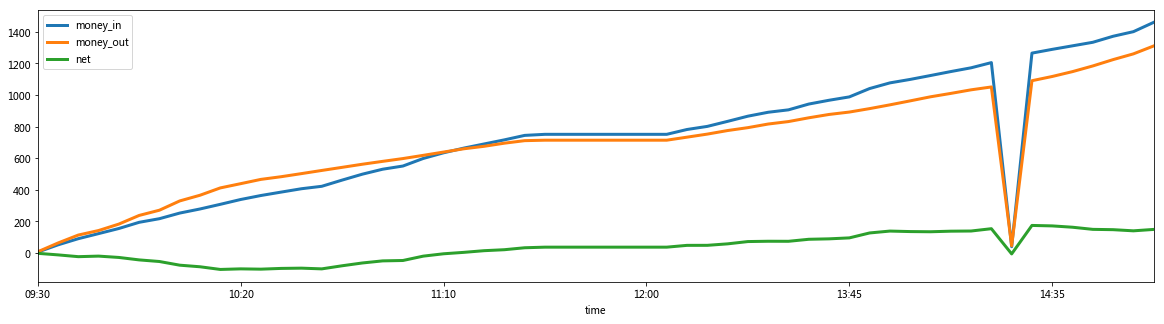

In [15]:
df.loc[df['date']=='2017-12-21',['time','money_in','money_out','net']].groupby('time').sum()\
.plot(figsize=(20,5),linewidth=3)

* 日净额/流入资金/流出资金趋势图  
    通过分析日净额/流入资金/流出资金情况可以观察近期股市的活跃程度，长期观察或许可以看出A股是牛市还是熊市

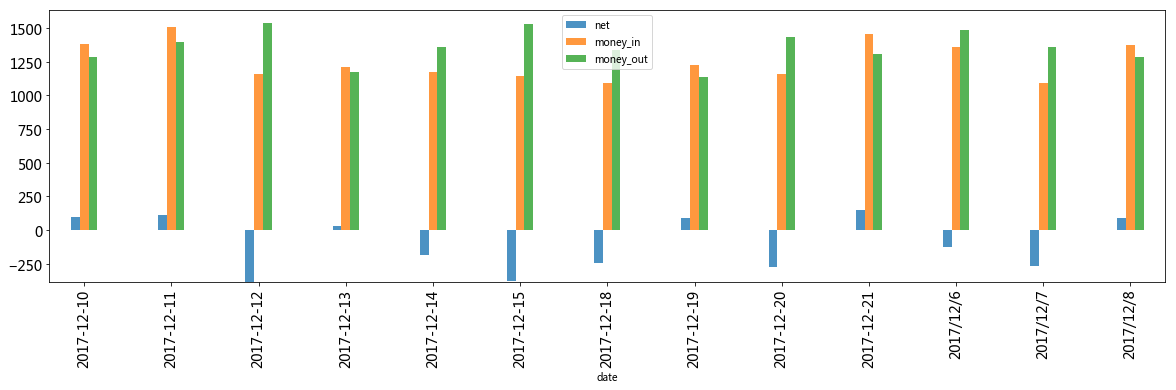

In [20]:
daily_money.sum().loc[:,['net','money_in','money_out']].plot(kind='bar',figsize=(20,5),alpha=0.8,width=0.3,fontsize=14)

* 查看近15天某行业的资金流动情况

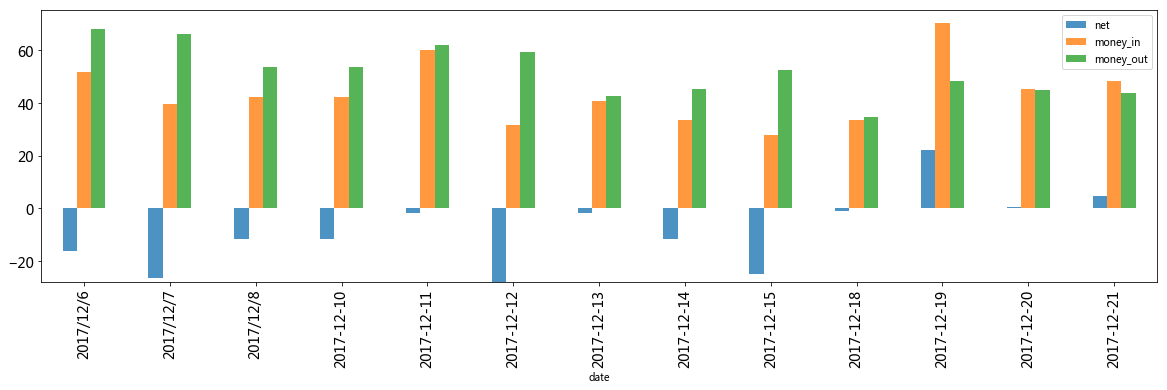

In [22]:
df.loc[(df['industry']=='银行')&(df['time']=='15:00'),['date','net','money_in','money_out']][-15:].set_index('date')\
.plot(kind='bar',figsize=(20,5),alpha=0.8,width=0.5,fontsize=14)

* 近15天流入资金/流出资金/净额TOP15行业

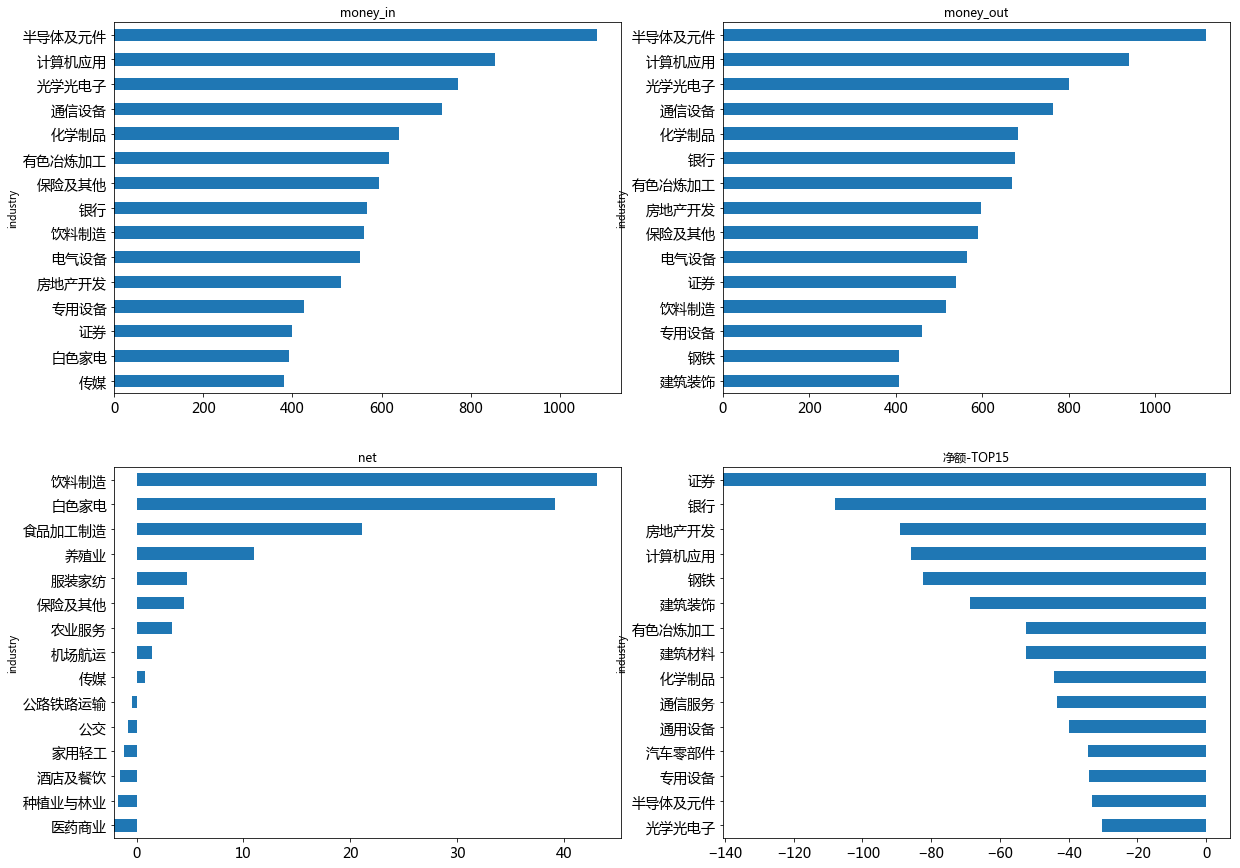

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
df.loc[(df['time']=='15:00')&(df['date']>=str(datetime.date(datetime.now()-timedelta(15))))]\
.groupby('industry').sum().sort_values('money_in',ascending=1)['money_in'][-15:].plot(kind='barh',fontsize=14,subplots=True,ax=axes[0][0])
plt.title('流入资金TOP15')
df.loc[(df['time']=='15:00')&(df['date']>=str(datetime.date(datetime.now()-timedelta(15))))]\
.groupby('industry').sum().sort_values('money_out',ascending=1)['money_out'][-15:].plot(kind='barh',fontsize=14,subplots=True,ax=axes[0][1])
plt.title('流出资金TOP15')
df.loc[(df['time']=='15:00')&(df['date']>=str(datetime.date(datetime.now()-timedelta(15))))]\
.groupby('industry').sum().sort_values('net',ascending=1)['net'][-15:].plot(kind='barh',fontsize=14,subplots=True,ax=axes[1][0])
plt.title('净额TOP15')
df.loc[(df['time']=='15:00')&(df['date']>=str(datetime.date(datetime.now()-timedelta(15))))]\
.groupby('industry').sum().sort_values('net',ascending=0)['net'][-15:].plot(kind='barh',fontsize=14,subplots=True,ax=axes[1][1])
plt.title('净额-TOP15')

* **industry money flow**

注意到，源表是根据时间序列生成各个行业的资金流向（即每个时间点会生成66个行业的资金流向数据），为了分析各个行业的资金流动变化情况，需要对源表进行转变，使用pandas.pivot()/pandas.pivot_table()可以从原表派生出符合格式的表。

In [24]:
industry_df = df.pivot_table(index=['date','time'],columns='industry',values='net')
industry_df.head(7)

industry          专用设备   中药  交运设备服务  仪器仪表    传媒  保险及其他  光学光电子   公交  公路铁路运输  \
date       time                                                              
2017-12-10 09:30 -0.98  0.1    0.21 -0.33  4.38  16.73   8.92  0.1    0.83   
           09:35 -0.98  0.1    0.21 -0.33  4.38  16.73   8.92  0.1    0.83   
           09:40 -0.98  0.1    0.21 -0.33  4.38  16.73   8.92  0.1    0.83   
           09:45 -0.98  0.1    0.21 -0.33  4.38  16.73   8.92  0.1    0.83   
           09:50 -0.98  0.1    0.21 -0.33  4.38  16.73   8.92  0.1    0.83   
           09:55 -0.98  0.1    0.21 -0.33  4.38  16.73   8.92  0.1    0.83   
           10:00 -0.98  0.1    0.21 -0.33  4.38  16.73   8.92  0.1    0.83   

industry          其他电子  ...   通用设备    造纸  酒店及餐饮  采掘服务    钢铁     银行   零售  \
date       time         ...                                               
2017-12-10 09:30  2.72  ...  -2.56  0.83  -0.03  0.38  5.07 -11.59  1.1   
           09:35  2.72  ...  -2.56  0.83  -0.03  0.38  5.07 -11.59  1.1   
           09:40  2.72  ...  -2.56  0.83  -0.03  0.38  5.07 -11.59  1.1   
           09:45  2.72  ...  -2.56  0.83  -0.03  0.38  5.07 -11.59  1.1   
           09:50  2.72  ...  -2.56  0.83  -0.03  0.38  5.07 -11.59  1.1   
           09:55  2.72  ...  -2.56  0.83  -0.03  0.38  5.07 -11.59  1.1   
           10:00  2.72  ...  -2.56  0.83  -0.03  0.38  5.07 -11.59  1.1   

industry          非汽车交运  食品加工制造  饮料制造  
date       time                        
2017-12-10 09:30  -5.21    1.62   7.9  
           09:35  -5.21    1.62   7.9  
           09:40  -5.21    1.62   7.9  
           09:45  -5.21    1.62   7.9  
           09:50  -5.21    1.62   7.9  
           09:55  -5.21    1.62   7.9  
           10:00  -5.21    1.62   7.9  

[7 rows x 66 columns]

In [743]:
#行业列表
industry_df.columns

Index(['专用设备', '中药', '交运设备服务', '仪器仪表', '传媒', '保险及其他', '光学光电子', '公交', '公路铁路运输',
       '其他电子', '养殖业', '农业服务', '农产品加工', '包装印刷', '化学制品', '化学制药', '化工合成材料',
       '化工新材料', '医疗器械服务', '医药商业', '半导体及元件', '园区开发', '国防军工', '基础化学', '家用轻工',
       '建筑材料', '建筑装饰', '房地产开发', '新材料', '景点及旅游', '有色冶炼加工', '服装家纺', '机场航运',
       '汽车整车', '汽车零部件', '港口航运', '煤炭开采', '燃气水务', '物流', '环保工程', '生物制品', '电力',
       '电子制造', '电气设备', '白色家电', '石油矿业开采', '种植业与林业', '纺织制造', '综合', '视听器材',
       '计算机应用', '计算机设备', '证券', '贸易', '通信服务', '通信设备', '通用设备', '造纸', '酒店及餐饮',
       '采掘服务', '钢铁', '银行', '零售', '非汽车交运', '食品加工制造', '饮料制造'],
      dtype='object', name='industry')

In [953]:
# industry_df.loc[['2017-12-06','11:55'],['银行']]
# industry_df.iloc[[],[]]
industry_df.axes

[MultiIndex(levels=[['2017-12-06', '2017-12-07'], ['09:30', '09:35', '09:40', '09:45', '09:50', '09:55', '10:00', '10:05', '10:10', '10:15', '10:20', '10:25', '10:30', '10:35', '10:40', '10:45', '10:50', '10:55', '11:00', '11:05', '11:10', '11:15', '11:20', '11:25', '11:30', '11:35', '11:40', '11:45', '11:50', '11:55', '12:00', '13:00', '13:05', '13:10', '13:15', '13:20', '13:25', '13:30', '13:35', '13:40', '13:45', '13:50', '13:55', '14:00', '14:05', '14:10', '14:15', '14:20', '14:25', '14:30', '14:35', '14:40', '14:45', '14:50', '14:55', '15:00']],
            labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1

* 金融行业资金流向趋势

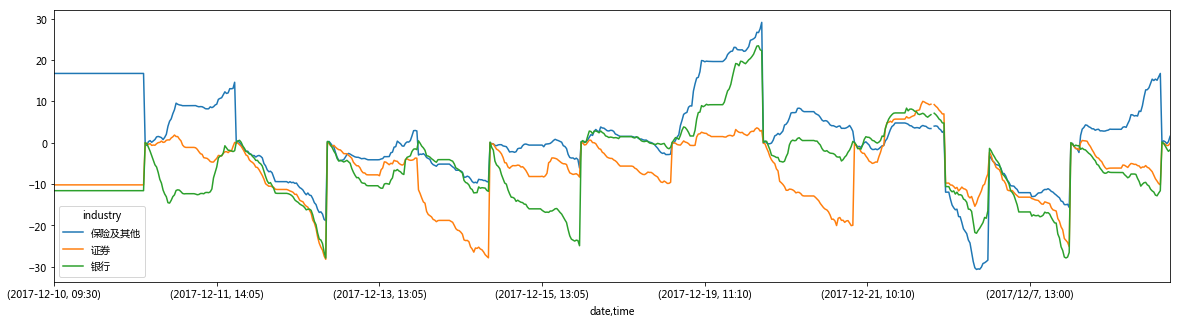

In [25]:
industry_df.loc[:,['保险及其他', '证券', '银行']].plot(kind='line',figsize=(20,5))

* 资源开采类行业资金流向趋势

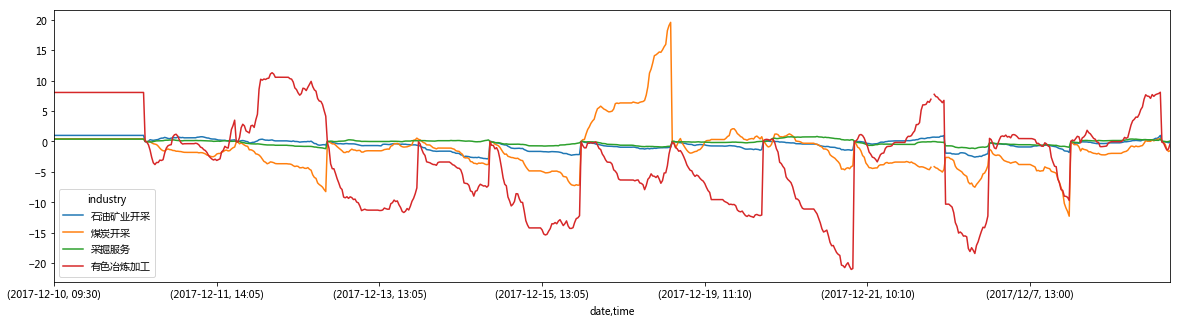

In [26]:
industry_df.loc[:,['石油矿业开采', '煤炭开采', '采掘服务','有色冶炼加工']].plot(figsize=(20,5),kind='line')

* 医疗相关行业资金流向趋势

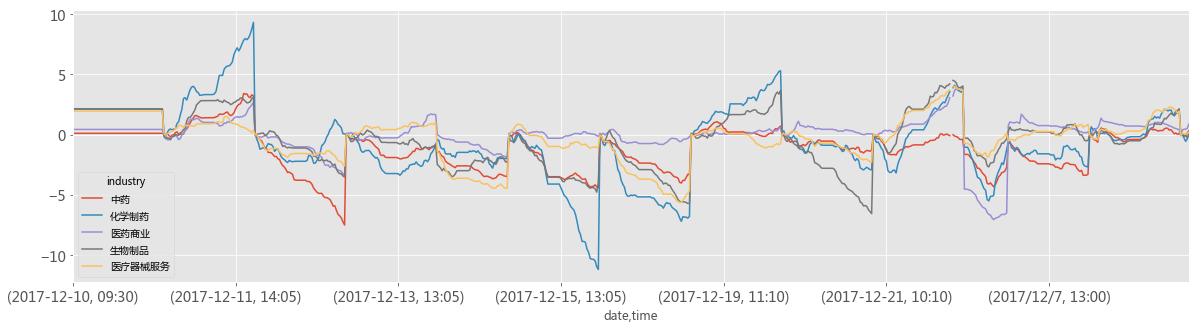

In [27]:
plt.style.use('ggplot')
industry_df.loc[:,[ '中药','化学制药','医药商业', '生物制品','医疗器械服务']].plot(kind='line',figsize=(20,5),fontsize=14)

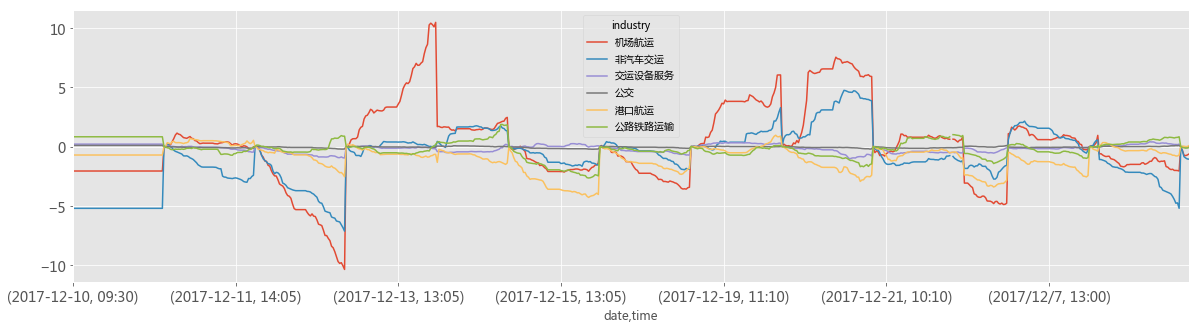

In [28]:
industry_df.loc[:,[ '机场航运','非汽车交运','交运设备服务', '公交','港口航运','公路铁路运输']].plot(kind='line',figsize=(20,5),fontsize=14)